## Prepare Project
### Import Libraries and set up database connection

In [47]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Import pandas
import pandas as pd

pd.set_option('display.width', 2000)

# Import logging and suppress warnings
import logging

logging.getLogger("neo4j").setLevel(logging.ERROR)
logging.getLogger("pd").setLevel(logging.ERROR)

# Import Path
from pathlib import Path

# Import promg
from promg import Query

#Import Seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from util.db_helper_functions import get_db_connection, get_graph_statistics
from util.assign_types_functions import add_object_type_node
from util.enrichment_methods import materialize_objects, extend_relationships, build_df_edges, \
    get_variant_length_statistics, infer_start_event, infer_end_event, \
    infer_high_level_events_based_on_start_and_end_events, get_activity_set_variants

## Set up connection

In [3]:
conf_path = Path('bpic14', 'config.yaml')
db_connection = get_db_connection(conf_path)

These are the credentials that I expect to be set for the database.
db_name: neo4j
uri: bolt://localhost:7687
password: bpic2014
----------------------
If you have other credentials, please change them at: bpic14\config.yaml


# 3. Analysis

## Iteration 0: Filter Data based on Timestamps

_Note: We did explain this filtering in the paper as this is focused on data preparation and not so much on enrichment_

**Exploration**
Since events for the Incidents can come from two different data sources (`BPIC14Incident.csv` and `Detail_Incident_Activity.csv`) we check whether the start and end of the Incidents termporally align.

Every Incident should start with its opening which is recorded in `BPIC14Incident.csv`.
Then it should be followed by an `Open` event on the `:DetailIncident` level.

Let's check whether that is the case.

In [4]:
succeeding_events_q = '''
    MATCH (e1:Event {activity: 'Open'}) - [:IS_OF_TYPE] -> (et:EventType {eventType: 'IncidentEvent'})
    CALL (e1) {
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WHERE e1.timestamp <= e2.timestamp AND e1 <> e2
        MATCH (e2) - [:IS_OF_TYPE] -> (et2:EventType)
        RETURN e2, et2 ORDER BY e2.timestamp ASC LIMIT 1
    }
    RETURN et.eventType + ':' + e1.activity as first_event, et2.eventType + ':' + e2.activity as second_event, count(e1) as count order by count DESC'''

df = pd.DataFrame(db_connection.exec_query(succeeding_events_q))
print(f"Total number of events: {sum(df['count'])}")
df

Total number of events: 46368


,first_event,second_event,count
0,IncidentEvent:Open,IncidentActivityEvent:Open,46368


Indeed, most `(IncidentEvent:Open)` are followed by a `(IncidentActivityEvent:Open)`, however there are some 46606-46369=237 events that are not followed by such event.

Let's check the minimum timestamp of the preceding event. It could be that for some cases, the `(IncidentActivityEvent:Open)` is not recorded because it falls outside the recording period.

In [5]:
succeeding_events_timestamp_q = '''
    MATCH (e1:Event {activity: 'Open'}) - [:IS_OF_TYPE] -> (et:EventType {eventType: 'IncidentEvent'})
    CALL (e1) {
        MATCH (e1) - [:CORR] -> (:Incident) <- [:CORR] - (e2)
        WHERE e1.timestamp <= e2.timestamp AND e1 <> e2
        MATCH (e2) - [:IS_OF_TYPE] -> (et2:EventType)
        RETURN e2, et2 ORDER BY e2.timestamp, e2.activity ASC LIMIT 1
    }
    WITH e1, e2, et2
    WHERE et2.eventType = 'IncidentActivityEvent'
    WITH min(e2.timestamp) as first_occurrence, et2.eventType + ':' + e2.activity as event, count(e1) as count order by count DESC
    RETURN first_occurrence, event, count order by first_occurrence DESC'''

df = pd.DataFrame(db_connection.exec_query(succeeding_events_timestamp_q))
df

,first_occurrence,event,count
0,2013-08-19T10:09:47.000000000+01:00,IncidentActivityEvent:Open,46368


The `(IncidentActivityEvent:Open)` occurs from 2013-08-19 and from then onwards, it is always the first event after the `(IncidentEvent:Open)`.

Let's check how many events we have before this date and after this date for any `(:Event)` node.


In [6]:
query_str = '''
        MATCH (e:Event) - [:IS_OF_TYPE] -> (et:EventType)
        RETURN et.eventType as eventType, date(e.timestamp) < date("2013-08-19") as before, count(e) as cnt ORDER BY eventType, before DESC
'''
result = pd.DataFrame(db_connection.exec_query(query_str))
table = pd.pivot_table(result, index=['eventType', 'before'], aggfunc="sum")
table['%'] = (round(table.cnt / table.groupby(level=0).cnt.transform("sum") * 100, 2)).astype(str) + '%'
print(table)

                                 cnt       %
eventType             before                
ChangeEvent           False    33217  100.0%
IncidentActivityEvent False   458748  100.0%
IncidentEvent         False   137336  100.0%
InteractionEvent      False   293106  100.0%


Most events (99.4%) happen after 2013-08-19.

Let's check how many objects have at least one event before this date.


In [7]:
query = '''
        MATCH (o) - [:CORR] - (e:Event)
        MATCH (e) - [:IS_OF_TYPE] -> (et:EventType)
        WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
        WITH o, collect(distinct before_cutoff) as before_cutoffs
        MATCH (o) - [:IS_OF_TYPE] -> (ot:ObjectType)
        RETURN ot.objectType as objectType, True in before_cutoffs as before, count(distinct o) as cnt
    '''

df_result = pd.DataFrame(db_connection.exec_query(query))
table = pd.pivot_table(df_result, index=['objectType', 'before'], aggfunc="sum")
table['%'] = (round(table.cnt / table.groupby(level=0).cnt.transform("sum") * 100, 2)).astype(str) + '%'
print(table)



                       cnt       %
objectType  before                
CI_SC       False    12910  100.0%
Change      False    16611  100.0%
Incident    False    46378  100.0%
Interaction False   146553  100.0%


Most object (99.6%) have only events after 2013-08-19.

**Filtering**
From domain knowledge (and verified by the data) we see that most `(IncidentEvent:Open)` are followed by a `(IncidentActivityEvent:Open)`. The very few that don't have a first succeeding event before 2013-08-19.

We decide to remove those objects that have at least one event before said date, as this only affects a small amount of objects. We also remove all associated events.

In [8]:
results = []

count_query = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - [] - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in ['Incident', 'Interaction', 'Change']
    WITH e, ot, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
    WITH ot, o, collect(distinct before_cutoff) as before_cutoffs
    WHERE True in before_cutoffs
    MATCH (o) - [] - (all_e) - [:IS_OF_TYPE] -> (et:EventType)
    RETURN ot.objectType as objectType, count(distinct o) as object_deleted, count(distinct all_e) as events_deleted
'''

df_deleted = pd.DataFrame(db_connection.exec_query(count_query))

delete_query_str = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - [] - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in ['Incident', 'Interaction', 'Change']
    WITH e, o, e.timestamp < dateTime("2013-08-19T09:59:53.000000000+01:00") as before_cutoff
    WITH o, collect(distinct before_cutoff) as before_cutoffs
    WHERE True in before_cutoffs
    MATCH (o) - [] - (all_e) - [:IS_OF_TYPE] -> (et:EventType)
    DETACH DELETE o
    DETACH DELETE all_e
'''

db_connection.exec_query(delete_query_str);

Let's also count the number of objects and events we kept.

In [9]:
kept_count_query = '''
    MATCH (ot:ObjectType) <- [:IS_OF_TYPE] - (o) - []  - (e) - [:IS_OF_TYPE] -> (et:EventType)
    WHERE ot.objectType in  ['Incident', 'Interaction', 'Change']
    RETURN ot.objectType as objectType, count(distinct o) as objects_kept, count(distinct e) as events_kept
'''

df_kept = pd.DataFrame(db_connection.exec_query(kept_count_query))

In [10]:
df_both = df_deleted.set_index('objectType').join(df_kept.set_index('objectType'))
df_both['total_objects'] = df_both['objects_kept'] + df_both['object_deleted']
df_both['total_events'] = df_both['events_kept'] + df_both['events_deleted']
df_both['% events deleted'] = round(df_both['events_deleted'] / df_both['total_events'] * 100, 2)
df_both['% objects deleted'] = round(df_both['object_deleted'] / df_both['total_objects'] * 100, 2)
df_both = df_both[
    ['object_deleted', 'objects_kept', 'total_objects', '% objects deleted', 'events_deleted', 'events_kept',
     'total_events', '% events deleted']]
df_both

KeyError: "None of ['objectType'] are in the columns"

## Iteration 1: Enrich with a dedicated CI-SC object

**Materialize CI-SC object**

To analyze the lifecycle of a CI, we first assessed its global uniqueness. Our domain model reveals a many-to-many relationship between CIs and SCs. Upon reflection, we found that CIs are locally unique within each SC, making the CI-SC pair the true object of interest. We materialized this relationship as a distinct object, CI-SC, using _Enrich Method 1: Materializing Objects_.

In [ ]:
objects_to_materialize = {
    "CI_SC": [{
        "from_object": {
            "label": "ServiceComponent"
        },
        "to_object": {
            "label": "ConfigurationItem",
            "attributes": {  # copy over attributes
                "ciType": "ciType",
                "ciSubtype": "ciSubtype"
            }
        },
        "relation_type": "CONTAINS"
    }]
}

In [ ]:
materialize_objects(_db_connection=db_connection,
                    _objects_to_materialize=objects_to_materialize)

Results should show that we created 15327 `(:CI_SC)` nodes.

**Materialize O2O relationships**

We lift the relations from Incidents, Interactions, Changes _o_ to the newly materialized CI-SC pair _ci-sc_ if _o_ is related to both the _ci_ and _sc_ of which the _ci-sc_ pair is composed of using _Enrichment Method 3: Infer O2O_ relationship.

More specifically, we lift the `:AFFECTED_CI` and `:AFFECTED_SC` relationship into `:AFFECTED_CISC` and `:CAUSED_BY_CI` and `:CAUSED_BY_SC` into `:CAUSED_BY_CI_SC`.

In [ ]:
o2o_relationships_to_extend = {
    "AFFECTED_CI_SC": [{
        "from_object": {
            "label": "Incident|Interaction|Change",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "AFFECTED_SC"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "AFFECTED_CI"
                }]
        },
        "to_object": {
            "label": "CI_SC",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "RELATED"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "RELATED"
                }]
        }
    }],
    "CAUSED_BY_CI_SC": [{
        "from_object": {
            "label": "Incident",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "CAUSED_BY_SC"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "CAUSED_BY_CI"
                }]
        },
        "to_object": {
            "label": "CI_SC",
            "relationships": [
                {
                    "related_label": "ServiceComponent",
                    "related_object": "sc",
                    "relation_type": "RELATED"
                },
                {
                    "related_label": "ConfigurationItem",
                    "related_object": "ci",
                    "relation_type": "RELATED"
                }]
        }
    }]
}

In [ ]:
extend_relationships(db_connection, o2o_relationships_to_extend)

Results should show that we extended with
- 222884 `(:Incident|Interaction|Change) - [:AFFECTED_CI_SC] -> (:CI_SC)` Relationships
- 42928 `(:Incident) - [:CAUSED_BY_CI_SC] -> (:CI_SC)` Relationships

**Materialize E2O relationships**

Since Incidents, Interactions, and Changes relate to one or more CI-SCs, analysts must track CI-SCs across process steps to understand recurring disruptions and their impact on Changes. Isolated views of Interactions, Incidents, or Changes are insufficient. Thus, we linked these events directly to CI-SC objects using _Enrichment Method 2: Infer E2O relations_.

In [ ]:
e2o_relationships_to_extend = {
    "CORR": [
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Change",
                        "related_object": "change",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Change",
                        "related_object": "change",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        },
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Incident",
                        "related_object": "incident",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Incident",
                        "related_object": "incident",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        },
        {
            "from_object": {
                "label": "Event",
                "relationships": [
                    {
                        "related_label": "Interaction",
                        "related_object": "interaction",
                        "relation_type": "CORR"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Interaction",
                        "related_object": "interaction",
                        "relation_type": "AFFECTED_CI_SC"
                    }]
            }
        }
    ],
}

In [ ]:
extend_relationships(db_connection, e2o_relationships_to_extend)

Results should show that we extend with
- 53413 `(:Event) - [:CORR] -> (:CI_SC)` Relationships (via `:Change`)
- 596012 `(:Event) - [:CORR] -> (:CI_SC)` Relationships (via `:Incident`)
- 293106 `(:Event) - [:CORR] -> (:CI_SC)` Relationships (via `:Interaction`)

**Materialize DF relationships**
We inferred the temporal order of the events as DF relationships with _Enrichment method 4: Inferring DF relationships_.

DF relationships are inferred for objects of a specific object type, we infer the relationships for the following objects as they are of interest to better understand the CI-SC lifecycle.
- Interaction
- Incident
- Change
- CI-SC

In [8]:
object_types_with_event_types = {
    'Interaction': ['InteractionEvent'],
    'Incident': ['IncidentEvent', 'IncidentActivityEvent'],
    'Change': ['ChangeEvent'],
    'CI_SC': ['InteractionEvent', 'IncidentEvent', 'IncidentActivityEvent', 'ChangeEvent']
}

In [9]:
for object_type, event_types in object_types_with_event_types.items():
    build_df_edges(db_connection, object_type, event_types)

→ Interaction DF creation result: 439659
→ Incident DF creation result: 642462
→ Change DF creation result: 49828
→ CI_SC DF creation result: 929621


Complex nesting patterns can be found when exploring the DF-edges visually.
For instance, Fig.6 (left) shows the trace of CI_SC with sysId: WBS000098_APP000003.

To visualize it for yourself, you can do the following steps:
1) In Neo4j Bloom, request CI_SC sysId: WBS000098_APP000003
2) Right-click the node to expand all related :Events by clicking Expand, :CORR
3) Select all events and reveal DF relationships.

To color the event nodes per event type, we first need to add an eventType property using the following query. Then on the right hand side, you can select Event, then go to rule based, add a rule-based styling based on eventType with unique colours.

In [ ]:
query = '''
MATCH (e:Event) - [:IS_OF_TYPE] -> (et:EventType)
SET e.eventType = et.eventType
'''

db_connection.exec_query(query);

## Iteration 2: Enrich with High-Level Events

### Variant Analysis
To understand the lifecycle of a CI SC, we want to perform variant analysis.
As this might be an expensive query, we first request some statistics.

In [4]:
get_variant_length_statistics(_db_connection=db_connection,
                              _object_type='CI_SC',
                              _event_types=['ChangeEvent', 'InteractionEvent', 'IncidentEvent',
                                            'IncidentActivityEvent'])

### Infer High Level Events
Since CI-SC lifecycles can span extensive periods, with an average of 73 events per CI-SC and up to 45,121 events, analyzing events at such a fine-grained level is impractical and misaligned with our objectives. Therefore, we lift the behavior analysis to a higher level of abstraction by introducing Higher-Level (HL) Events, inspired by _Enrichment Method : Infer High-Level Events_.

For our enrichment method, we want to capture the opening and closing times of associated Interactions, Incidents, and Changes.

Therefore, for each Interaction, Incident and Change, we should determine the first event (start event), the last event (end event).
To enable this, we enrich our datamodel by adding an E2O Relationship `(o) - [:START] -> (startEvent:Event)`  and `(o) - [:END] -> (endEvent:Event)` for each object `o` of a specific object type.

In [4]:
object_types_with_event_types = {
    'Interaction': ['InteractionEvent'],
    'Incident': ['IncidentEvent', 'IncidentActivityEvent'],
    'Change': ['ChangeEvent']
}

In [4]:
for object_type, event_types in object_types_with_event_types.items():
    infer_start_event(_db_connection=db_connection,
                      _object_type=object_type,
                      _event_types=event_types)
    infer_end_event(_db_connection=db_connection,
                    _object_type=object_type,
                    _event_types=event_types)



→ Inferred Start Events for 293106 objects (Interaction)
→ Inferred End Events for 293106 objects (Interaction)
→ Inferred Start Events for 92756 objects (Incident)
→ Inferred End Events for 92756 objects (Incident)
→ Inferred Start Events for 33227 objects (Change)
→ Inferred End Events for 33227 objects (Change)


Using this E2O enrichment, we can infer `(:HighLevelEvent)` nodes. For each object `o` we determine the `startEvent` and `endEvent` and create a new `(:HighLevelEvent)` with `startTime = startEvent.timestamp` and `endTime = endEvent.timestamp`.

As event type, we will add that it is an 'HighLevelEvent'. The method also automatically extends the E2O relationship between the object of the specific object type and the lower level event to the object and its higher-level events.

In [5]:
for object_type in object_types_with_event_types.keys():
    infer_high_level_events_based_on_start_and_end_events(_db_connection=db_connection,
                                                          _object_type=object_type,
                                                          _hle_event_type='HighLevelEvent')

→ Inferred 146553 (:HighLevelEvent) of type HighLevelEvent for ObjectType (Interaction)
→ Inferred 46378 (:HighLevelEvent) of type HighLevelEvent for ObjectType (Incident)
→ Inferred 16611 (:HighLevelEvent) of type HighLevelEvent for ObjectType (Change)


In [13]:
count_events = '''
MATCH (e:HighLevelEvent)
RETURN e.activity, count(e)
'''

db_connection.exec_query(count_events)

[{'e.activity': 'Interaction', 'count(e)': 146553},
 {'e.activity': 'Incident', 'count(e)': 46378},
 {'e.activity': 'Change', 'count(e)': 16611}]

### Extend E2O Relationships
While we have extended the E2O relationships from the object of the following object type (Interaction, Incident and Change), we still need to extend the relationship from the HLE to the objects of object type CI-SC.

In [6]:
hle2o_relationships_to_extend = {
    "CORR": [
        {
            "from_object": {
                "label": "HighLevelEvent",
                "relationships": [
                    {
                        "related_label": "Event",
                        "related_object": "event",
                        "relation_type": "START"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Event",
                        "related_object": "event",
                        "relation_type": "CORR"
                    }]
            }
        }, {
            "from_object": {
                "label": "HighLevelEvent",
                "relationships": [
                    {
                        "related_label": "Event",
                        "related_object": "event",
                        "relation_type": "END"
                    }]
            },
            "to_object": {
                "label": "CI_SC",
                "relationships": [
                    {
                        "related_label": "Event",
                        "related_object": "event",
                        "relation_type": "CORR"
                    }]
            }
        }
    ]
}

In [7]:
extend_relationships(_db_connection=db_connection, _relationships=hle2o_relationships_to_extend)

→ 219630 (:HighLevelEvent) - [:CORR] -> (:CI_SC) Relationship built
→ 219630 (:HighLevelEvent) - [:CORR] -> (:CI_SC) Relationship built


In [9]:
hle_object_types_with_event_types = {
    'CI_SC': {
        'eventTypes': ['HighLevelEvent'],
        'timestampFields': ['startTime', 'endTime']
    }
}

### Infer DF Relationships
 Next, we infer DF relationships for HL Events for CI-SCs using _Enrichment Method 4: Inferring DF Relationships_. At this level of abstraction, CI-SC lifecycles average 17 HL Events, with a maximum of 11,065 HL Events.

In [10]:
for object_type, event_types_with_timefields in hle_object_types_with_event_types.items():
    event_types = event_types_with_timefields['eventTypes']
    timestamp_fields = event_types_with_timefields['timestampFields']

    build_df_edges(db_connection, _object_type=object_type, _event_types=event_types,
                   _timestamp_fields=timestamp_fields)

→ CI_SC DF creation result: 330608


We can now explore the lifecycles of CI-SC objects at a higher granularity using the `(:HigherLevelEvent)` nodes.
For instance, Fig.6 (right) shows the trace of CI_SC at a higher granularity with sysId: WBS000098_APP000003.

To visualize it for yourself, you can do the following steps:
1) In Neo4j Bloom, request CI_SC sysId: WBS000098_APP000003
2) Right-click the node to expand all related :Events by clicking Expand > Advanced Expression > Pairs > `:CORR HighlevelEvent`
3) Select all events and reveal DF relationships, if desired the `:CORR` relationships can be dismissed by selecting all `:CORR` relationships and then dismiss them.

To color the `:HighLevelEvent` nodes per activity, on the right hand side, you can select HighLevelEvent, then go to rule based, add a rule-based styling based on `activity` with unique colours.

### Perform Variant Analysis
To understand the lifecycle of a CI SC, we want to perform variant analysis again, but on on the higher level events.
As this might be an expensive query, we first request some statistics.

In [6]:
get_variant_length_statistics(_db_connection=db_connection,
                              _object_type='CI_SC',
                              _event_types=['HighLevelEvent'])

,min_length,max_length,avg_length,stDev_length
0,1,11065,17.012393,216.912633


Retrieving all variants will be too expensive, we will use set variants, a simplified representation that captures whether an activity occurred.
The set variants will reduce complex, lengthy lifecycles into a more interpretable form.

In [4]:
set_variants = get_activity_set_variants(_db_connection=db_connection,
                          _object_type='CI_SC',
                          _event_types=['HighLevelEvent'])

,set_variant,count_objects,%_set_variant
0,(Change),8212,63.61
1,(Incident) - (Interaction),2038,15.79
2,(Interaction),1554,12.04
3,(Change) - (Incident) - (Interaction),531,4.11
4,(Incident),472,3.66
5,(Change) - (Interaction),71,0.55
6,(Change) - (Incident),32,0.25


Our analysis reveals that
- 63.6% of CISC are managed exclusively through Changes (variant 0)
- 31.5% through Interactions and/or Incidents (variants 1, 2, 4: 15.79+12.04+3.66 = 31.49)
- The remaining 4.9% involve all three types of events (variants 4, 5, 6: 4.11+0.55+0.25 = 4.91)

## Iteration 3: Enrich Domain-Perspective with Set Variants Feature
The set variants reveal an imbalance in how CI-SCs are managed: some are managed exclusively through Changes, while others are addressed via Interactions and Incidents. To assess whether this imbalance is expected or unusual, we enrich the domain model with a new process feature _exposure level_ using a custom enrichment method based on _Enrichment Method 8: Inferring Features_.

We define three exposure levels:
- **Exposed** CI-SCs are highly accessible to employees, resulting in frequent Interactions and Incidents but no Changes.
- **Internal** CI-SCs undergo Changes without associated Interactions or Incidents.
- **Combined** CI-SCs exhibit both Changes and Interactions/Incidents.

In [6]:
def assign_exposure_level(_db_connection, _object_type, _event_types):
    q_assign_exposure_level_str = '''
        MATCH (:ObjectType {objectType: $objectType}) <- [:IS_OF_TYPE] - (o) -- (e) - [:IS_OF_TYPE] -> (et:EventType)
        WHERE et.eventType IN $eventTypes
        WITH o, e.activity AS activity ORDER BY activity
        WITH o, collect(distinct activity) as set_variant
        WITH o, set_variant,
        CASE
            WHEN size(set_variant) = 1 AND 'Change' in set_variant THEN 'internal'
            WHEN size(set_variant) > 1 AND 'Change' in set_variant THEN 'combined'
            ELSE 'exposed'
        END AS exposure
        SET o.exposure_level = exposure'''

    q_assign_exposure_level = Query(query_str=q_assign_exposure_level_str,
                                    parameters={
                                        'objectType': _object_type,
                                        'eventTypes': _event_types
                                    })

    db_connection.exec_query(q_assign_exposure_level)

In [7]:
event_types = ['HighLevelEvent']
assign_exposure_level(_db_connection=db_connection,
                      _object_type='CI_SC',
                      _event_types=event_types)

Let's explore the number of exposure levels we have per CI-SC Type

In [16]:
query = '''
MATCH (o:CI_SC)
WHERE o.exposure_level is not null AND o.ciType is not null
RETURN o.ciType as ciscType, o.exposure_level as exposure_level, count(o) as count
'''

exposure_level_per_type = pd.DataFrame(db_connection.exec_query(query))

In [17]:
exposure_level_per_type

,ciscType,exposure_level,count
0,storage,internal,293
1,storage,exposed,28
2,computer,exposed,3159
3,application,combined,314
4,hardware,exposed,47
5,application,exposed,363
6,computer,internal,3740
7,subapplication,exposed,89
8,application,internal,1012
9,subapplication,internal,365


There are also some cisc types that are of type `no type` or `#N/B`. We filter these results.

In [18]:
exposure_level_per_type_filtered = exposure_level_per_type[~ exposure_level_per_type['ciscType'].isin(['no type', '#N/B'])]

In [19]:
exposure_level_per_type_filtered

,ciscType,exposure_level,count
0,storage,internal,293
1,storage,exposed,28
2,computer,exposed,3159
3,application,combined,314
4,hardware,exposed,47
5,application,exposed,363
6,computer,internal,3740
7,subapplication,exposed,89
8,application,internal,1012
9,subapplication,internal,365


Let's determine per ciscType, the relative percentage of internal, exposed and combined CI-SCs.

In [43]:
# Group by ciscType and exposure_level, summing the counts
grouped = exposure_level_per_type_filtered.groupby(['ciscType', 'exposure_level'], as_index=False).sum()

# Calculate the total count for each ciscType
total_counts = grouped.groupby('ciscType')['count'].transform('sum')

# Calculate the relative proportion
grouped['relative_proportion'] = round(grouped['count'] / total_counts, 2)

# Pivot the table to get one row per ciscType
pivoted = grouped.pivot(
    index='ciscType',
    columns='exposure_level',
    values='relative_proportion'
).reset_index()

# Fill NaN values with 0 (for ciscTypes missing certain exposure_levels)
pivoted = pivoted.fillna(0)
pivoted = pivoted.sort_values(by=['combined'], ascending=[False])

# Display the result
pivoted

exposure_level,ciscType,combined,exposed,internal
1,application,0.19,0.21,0.60
10,storage,0.16,0.07,0.77
6,hardware,0.09,0.20,0.71
11,subapplication,0.09,0.18,0.73
9,software,0.02,0.08,0.90
7,networkcomponents,0.02,0.10,0.88
3,computer,0.02,0.45,0.53
4,database,0.01,0.02,0.97
8,officeelectronics,0.01,0.89,0.11
0,Phone,0.00,0.02,0.98


Building on the exposure level, we retrieve domain-level statistics to determine the distribution of exposure levels across CI-SC types. Our findings reveal that CI-SCs such as display devices and office electronics are highly exposed, whereas databases and software are predominantly internal. This domain-specific pattern explains the imbalance in set variants observed in Iteration Step 2: Rabobank employees interact more frequently with display devices than with databases, resulting in distinct set variant behaviors.

This finding also guides our next step: only some CI-SC types (i.e., hardware, subapplication, storage, and application) exhibit a significant number of Combined instances. Since our focus is on analyzing CI-SC subject to Interactions, Incidents, and Changes, we select these types as our subset for further analysis.


## Iteration 4: Explore how CI-SCs of selected subset are managed together

Building on our previous findings, we focus our analysis on CI-SCs with a _combined_ exposure level. Through visual exploration, we examine the lifecycle of these CI-SCs.

We explore the first few events of `WBS000253_ADB000028` and `WBS000073_SBA000360`. For this, you can add the following query to the `Saved Query` in Neo4j Bloom (https://neo4j.com/docs/bloom-user-guide/current/bloom-tutorial/search-phrases-advanced/). Using conditional formatting and layout options, the figure in the paper can be obtained.

```MATCH (ci_sc:CI_SC)
WHERE ci_sc.sysId IN ['WBS000253_ADB000028', 'WBS000073_SBA000360']
MATCH (e:HighLevelEvent) - [:CORR] -> (ci_sc)
MATCH (e) - [df:DF] -> (e2)
WHERE e.startTime >= datetime("2013-10-01T17:04:00+01:00") AND  df.id=ci_sc.sysId
RETURN e, e2, ci_sc, df ORDER BY e.startTime LIMIT 15```

The example reveals that events managed through Changes often occur in batches, with pairs of CI-SCs frequently grouped. Shared Changes between these CI-SCs sometimes happen consecutively, but they can also be interrupted by individual Changes or Incidents. Notably, the internal CI-SC undergoes Changes (indirectly) due to Incident on the other CI-SC, underscoring the interconnectedness of CI-SCs across exposure levels and types.

## Iteration 5: Study how CI-SC pairs are managed jointly or seperately.

### Number of affected CI-SCs per Change
This finding prompts the question: Which CI-SCs are frequently managed together? For this, we can switch perspective to the domain to analyze the number of CI-SC affected per Change. We can obtain this result by querying using domain concepts (Requirement 1).

Let's first count how many changes affect 1 CI-SC, 2 CI-SCs and so on.

In [70]:
ci_scs_per_change_q = '''
    MATCH (ci_sc:CI_SC) <- [:AFFECTED_CI_SC] - (c:Change)
    WITH c, count(distinct ci_sc) as count

    RETURN count(c) as num_changes, count order by count
'''

change_count = pd.DataFrame(db_connection.exec_query(ci_scs_per_change_q))

# Assuming your table is in a DataFrame called df
total_changes = change_count['num_changes'].sum()

# Calculate the proportion for each group
change_count['proportion'] = change_count['num_changes'] / total_changes

change_count

,num_changes,count,proportion
0,13980,1,0.780221
1,2071,2,0.115582
2,619,3,0.034546
3,563,4,0.031421
4,156,5,0.008706
5,173,6,0.009655
6,50,7,0.002790
7,93,8,0.005190
8,35,9,0.001953
9,36,10,0.002009


The results indicate that 78.0% of Changes affect only one CI-SC, while 18.2% impact 2–4 CI-SC, with a maximum of 1,007 CI-SC affected by a single Change.

In [65]:
ci_scs_per_change_q = '''
    MATCH (ci_sc:CI_SC) <- [:AFFECTED_CI_SC] - (c:Change)
    WITH c, count(distinct ci_sc) as count
    RETURN c.sysId, count
'''

ci_scs_per_change = pd.DataFrame(db_connection.exec_query(ci_scs_per_change_q))

Let's also plot these results

In [71]:
def create_strip_plot(df):
    # Set the figure size (width, height) in inches
    plt.figure(figsize=(2, 3))  # Adjust the values as needed

    sns.stripplot(df, y='count', alpha=.2);
    plt.xlabel("Number of CI-SCs")
    plt.ylabel("")
    plt.show();


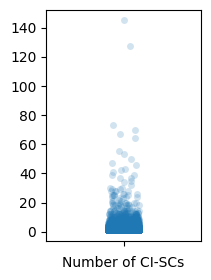

In [72]:
create_strip_plot(ci_scs_per_change)

We have one outlier, of more than a 1000 affecred CI-SCs. Let's remove this one to get a better view of the number of affected CI-SCs per change.

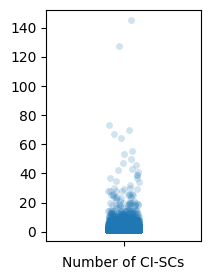

In [73]:
ci_scs_per_change = ci_scs_per_change[ci_scs_per_change['count'] < 1000]
create_strip_plot(ci_scs_per_change)

### Affected CI_SCs in a single change per type.

In [80]:
ci_scs_per_change_q = '''
    MATCH (ci_sc:CI_SC) <- [:AFFECTED_CI_SC] - (c:Change)
    WITH c, collect(distinct ci_sc.ciType) as ci_scTypes, count(distinct ci_sc) as count
    WHERE count > 1
    RETURN count(c) as num_changes, ci_scTypes, count
'''

ci_scs_and_types_per_change = pd.DataFrame(db_connection.exec_query(ci_scs_per_change_q))

In [81]:
ci_scs_and_types_per_change

,num_changes,ci_scTypes,count
0,7,"[software, application]",2
1,248,[application],2
2,485,[computer],2
3,32,[software],3
4,57,[computer],6
...,...,...,...
321,1,[applicationcomponent],20
322,1,"[software, subapplication]",2
323,1,[applicationcomponent],17
324,1,[applicationcomponent],25


Additionally, Changes often affect CI-SCs of the same type but can also involve pairs of different types, such as (Database, Application) or (Phone, Network Components).

Explorotary analysis at the subtype level also reveals that Changes to Phone Numbers sometimes align with modifications to Network Component Lines, which in turn align with domain understanding.

### Process Perstive on Shared Changes
From a process perspective, we examined whether shared Changes between \ciscs occur consecutively or are interrupted by other events using a custom query (Requirement 3).

In [89]:
def get_ci_scs_in_sync(db_connection):
    query = '''
            :auto
        MATCH (e:HighLevelEvent) - [:CORR] -> (o1) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
    MATCH (e) - [:CORR] -> (o2) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
    WHERE o1 < o2
    WITH e, o1, o2
    CALL (e, o1, o2){
      MATCH (f:HighLevelEvent)  - [:CORR] -> (o1)
      MATCH (f) - [:CORR] -> (o2)
      WHERE f.startTime >= e.startTime AND e <> f
      RETURN f ORDER BY f.startTime limit 1
    } IN TRANSACTIONS
    CALL (o1, e, f){
      MATCH p = SHORTEST 1 (e) - [:DF* {id: o1.sysId}] -> (f)
      WITH p, nodes(p)[1..-1] as events
      CALL (events) {
        UNWIND events as event
        WITH event ORDER BY event.activity
        RETURN collect(distinct event.activity) as set_variant
        }
      RETURN nodes(p) as p_o1, set_variant as set_variant_o1
    } IN TRANSACTIONS
    CALL (o2, e, f){
        MATCH p = SHORTEST 1 (e) - [:DF* {id: o2.sysId}] -> (f)
      WITH p, nodes(p)[1..-1] as events
      CALL (events) {
        UNWIND events as event
        WITH event ORDER BY event.activity
        RETURN collect(distinct event.activity) as set_variant
        }

      RETURN nodes(p) as p_o2,  set_variant as  set_variant_o2

    } IN TRANSACTIONS
        MATCH (o1) - [:RELATED] -> (ci1:ConfigurationItem)
        MATCH (o2) - [:RELATED] -> (ci2:ConfigurationItem)
        WITH o1, ci1, o2, ci2, p_o1, p_o2, set_variant_o1, set_variant_o2

        CALL (set_variant_o1, set_variant_o2) {
        WITH set_variant_o1, set_variant_o2, CASE
            WHEN size(set_variant_o1) <= size(set_variant_o2) THEN set_variant_o1
            ELSE set_variant_o2 END AS first_interruptions
        WITH set_variant_o1, set_variant_o2, first_interruptions, CASE
            WHEN first_interruptions = set_variant_o1 THEN set_variant_o2
            ELSE set_variant_o1 END AS second_interruptions
        WITH set_variant_o1, set_variant_o2, CASE
            WHEN size(first_interruptions) = 0 THEN " None"
            ELSE ltrim(reduce(init="", item in first_interruptions | init + "-" + item), '-')  END AS interruptions_o1,
        CASE
            WHEN size(second_interruptions) = 0 THEN " None"
            ELSE ltrim(reduce(init="", item in second_interruptions | init + "-" + item), '-') END AS interruptions_o2
        RETURN interruptions_o1, interruptions_o2}
    RETURN interruptions_o1, interruptions_o2, count(o1) as occurrences

    '''

    result = pd.DataFrame(db_connection.exec_query(query=query))
    table = pd.pivot_table(result, index=['interruptions_o1', 'interruptions_o2'], aggfunc="sum")
    table['%'] = (
        round(
            table.groupby(['interruptions_o1', 'interruptions_o2']).occurrences.transform("sum") /
            sum(table.occurrences) * 100,
            2
        )
    )
    return table


In [90]:
result = get_ci_scs_in_sync(db_connection)
result = result.reset_index()


In [91]:
result

,interruptions_o1,interruptions_o2,occurrences,%
0,None,None,7987,61.35
1,None,Change,2395,18.40
2,None,Change-Incident,3,0.02
3,None,Change-Incident-Interaction,82,0.63
4,None,Change-Interaction,49,0.38
5,None,Incident,7,0.05
6,None,Incident-Interaction,94,0.72
7,None,Interaction,49,0.38
8,Change,Change,2038,15.65
9,Change,Change-Incident,7,0.05


61.4% of shared Changes are consecutive, while 34.05% (row 1+8) are interrupted by at least one Change.
Rarely (3.1%), both CI-SCs are interrupted by Interaction and/or Incidents.

### Same query but also per type

In [92]:
def get_ci_scs_in_sync(db_connection):
    query = '''
            :auto
        MATCH (e:HighLevelEvent) - [:CORR] -> (o1) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
    MATCH (e) - [:CORR] -> (o2) - [:IS_OF_TYPE] -> (ot:ObjectType {objectType:'CI_SC'})
    WHERE o1 < o2
    WITH e, o1, o2
    CALL (e, o1, o2){
      MATCH (f:HighLevelEvent)  - [:CORR] -> (o1)
      MATCH (f) - [:CORR] -> (o2)
      WHERE f.startTime >= e.startTime AND e <> f
      RETURN f ORDER BY f.startTime limit 1
    } IN TRANSACTIONS
    CALL (o1, e, f){
      MATCH p = SHORTEST 1 (e) - [:DF* {id: o1.sysId}] -> (f)
      WITH p, nodes(p)[1..-1] as events
      CALL (events) {
        UNWIND events as event
        WITH event ORDER BY event.activity
        RETURN collect(distinct event.activity) as set_variant
        }
      RETURN nodes(p) as p_o1, set_variant as set_variant_o1
    } IN TRANSACTIONS
    CALL (o2, e, f){
        MATCH p = SHORTEST 1 (e) - [:DF* {id: o2.sysId}] -> (f)
      WITH p, nodes(p)[1..-1] as events
      CALL (events) {
        UNWIND events as event
        WITH event ORDER BY event.activity
        RETURN collect(distinct event.activity) as set_variant
        }

      RETURN nodes(p) as p_o2,  set_variant as  set_variant_o2

    } IN TRANSACTIONS
        MATCH (o1) - [:RELATED] -> (ci1:ConfigurationItem)
        MATCH (o2) - [:RELATED] -> (ci2:ConfigurationItem)
        WITH o1, ci1, o2, ci2, p_o1, p_o2, set_variant_o1, set_variant_o2

        CALL (set_variant_o1, set_variant_o2) {
        WITH set_variant_o1, set_variant_o2, CASE
            WHEN size(set_variant_o1) <= size(set_variant_o2) THEN set_variant_o1
            ELSE set_variant_o2 END AS first_interruptions
        WITH set_variant_o1, set_variant_o2, first_interruptions, CASE
            WHEN first_interruptions = set_variant_o1 THEN set_variant_o2
            ELSE set_variant_o1 END AS second_interruptions
        WITH set_variant_o1, set_variant_o2, CASE
            WHEN size(first_interruptions) = 0 THEN " None"
            ELSE ltrim(reduce(init="", item in first_interruptions | init + "-" + item), '-')  END AS interruptions_o1,
        CASE
            WHEN size(second_interruptions) = 0 THEN " None"
            ELSE ltrim(reduce(init="", item in second_interruptions | init + "-" + item), '-') END AS interruptions_o2
        RETURN interruptions_o1, interruptions_o2}
    RETURN o1.ciType as c1Type, o1.ciType as c2Type, interruptions_o1, interruptions_o2, count(o1) as occurrences

    '''

    result = pd.DataFrame(db_connection.exec_query(query=query))
    table = pd.pivot_table(result, index=['interruptions_o1', 'interruptions_o2', 'c1Type', 'c2Type'], aggfunc="sum")
    table['%'] = (
        round(
            table.groupby(['c1Type', 'c2Type', 'interruptions_o1', 'interruptions_o2']).occurrences.transform("sum") /
            table.groupby(['c1Type', 'c2Type']).occurrences.transform("sum") * 100,
            2
        )
    )
    return table


In [93]:
result = get_ci_scs_in_sync(db_connection)
result = result.reset_index()

Filter on those interruptions that have at least an Incident and/or Interaction interruption for both CI-SCs.

In [107]:
result = result[
    (result['interruptions_o1'].str.contains('Incident') | result['interruptions_o1'].str.contains('Interaction')) & (
            result['interruptions_o2'].str.contains('Incident') | result['interruptions_o2'].str.contains(
        'Interaction'))]
table = pd.pivot_table(result, index=['interruptions_o1', 'interruptions_o2', 'c1Type', 'c2Type'], aggfunc="sum")
table

%  occurrences
interruptions_o1            interruptions_o2            c1Type      c2Type                        
Change-Incident             Change-Incident-Interaction application application  0.13            1
                                                        storage     storage      0.24            1
Change-Incident-Interaction Change-Incident-Interaction application application  2.38           19
                                                        computer    computer     0.06            3
                                                        hardware    hardware     0.67            1
Change-Interaction          Change-Incident             computer    computer     0.02            1
                            Change-Incident-Interaction application application  1.51           12
                                                        computer    computer     0.20           11
                            Change-Interaction          computer    computer     0.02            1
Incident                    Change-Incident-Interaction application application  0.13            1
                            Change-Interaction          application application  0.13            1
Incident-Interaction        Change-Incident-Interaction application application  0.63            5
                                                        computer    computer     0.06            3
                            Change-Interaction          application application  0.13            1
                                                        computer    computer     0.06            3
                            Incident-Interaction        application application  1.51           12
                                                        computer    computer     0.26           14
Interaction                 Change-Incident             application application  0.13            1
                            Change-Incident-Interaction application application  0.75            6
                                                        computer    computer     0.04            2
                            Change-Interaction          application application  0.25            2
                                                        computer    computer     0.06            3
                            Incident-Interaction        application application  1.00            8
                                                        computer    computer     0.18           10
                                                        storage     storage      0.24            1
                            Interaction                 application application  0.13            1
                                                        computer    computer     0.04            2
                                                        storage     storage      0.24            1

Let's count all occurrences and all occurrences that have a type of either application or computer.

In [113]:
total_occurrences = sum(table.occurrences)
table=table.reset_index()
application_or_computer_occurrences = sum(table[(table['c1Type'].isin(['application', 'computer'])) | (table['c2Type'].isin(['application', 'computer']))]['occurrences'])

In [115]:
print(f'Off all changes interrupted by an Incident or an Interaction for both CI-SCs, for {round(application_or_computer_occurrences/total_occurrences*100,2)}% have type either application or computer')

Off all changes intterrupted by an Incident or an Interaction for both CI-SCs, for 96.85% have type either application or computer
